In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import numpy as np

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder
    )

from sde.experiment_reports import \
    (
        plot_results_functions
    )


tfd = tfp.distributions

In [2]:
# notebook parameters
random_seed = 1
step_size = np.array(5e-2)
n_pts = 10000
n_pts_test = 250
low, high = 1, 2

n_layers = 3
n_dim_per_layer = 25

n_dimensions = 1  # only 1 is possible for Milstein

LEARNING_RATE = 1e-4
VALIDATION_SPLIT = .05
BATCH_SIZE = 32
N_EPOCHS = 100
ACTIVATION = tf.nn.elu

# only diagonal, because we are in 1D and use Milstein
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

data shape (10000, 1)


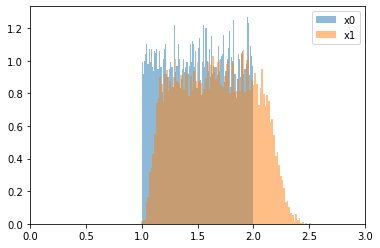

In [3]:
# Example: Geometric Brownian Motion
gbm_mu = 2
gbm_sigma = .2


def true_drift(x):
    return gbm_mu*x


def true_diffusivity(x):
    return gbm_sigma * x


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


def sample_data_gbm(step_size, rng, n_dimensions=1, n_pts=100, low=-1, high=1):
    x0 = rng.uniform(low=low, high=high, size=(n_pts, n_dimensions))
    dB = rng.normal(loc=0, scale=np.sqrt(step_size), size=(n_pts, n_dimensions))
    x1 = np.zeros_like(x0)
    for k in range(x0.shape[0]):
        B  = dB[k,:]  # we only need one step
        x1[k, :] = x0[k, :] * np.exp((gbm_mu - 0.5*gbm_sigma**2)*step_size + gbm_sigma * B)
    return x0, x1


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data_gbm(step_size=step_size, n_dimensions=n_dimensions,
                             low=low, high=high, n_pts=n_pts, rng=rng)
x_data_test, y_data_test = sample_data_gbm(step_size=step_size, n_dimensions=n_dimensions,
                             low=low, high=high, n_pts=n_pts_test, rng=rng)
print('data shape', x_data.shape)

fig,ax = plt.subplots(1,1)
ax.hist(x_data, 100, alpha=0.5, density=True, label="x0")
ax.hist(y_data, 100, alpha=0.5, density=True, label="x1");
ax.set_xlim([0,3])
ax.legend();

In [4]:
class GPModelSimple2(tf.keras.Model):
    """
    This is a very simple model, essentially just a Gaussian process on x_n that predicts the drift and diffusivity
    """

    def __init__(self,
                 encoder: tf.keras.Model,
                 step_size = None,
                 method = "euler",
                 **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.step_size = step_size
        self.method = method

        self.verify()
    
    def verify(self):
        if not(self.method in ["euler", "milstein"]):
            raise ValueError(self.method + " is not a valid method. Use <euler> or <milstein>.")

    @staticmethod
    def milstein_pdf(ynp1_, yn_, h_, model_):
        """
        Computes the probability density of y(n+1) given y(n), of the Milstein method,
        for the sde
        
        dX_t = drift_(X_t) dt + diffusivity_(X_t) dB_t.
        
        Note: currently the wrong Bessel function is used (nu=0 instead of nu=-1/2),
        because TensorFlow does not have real-valued Bessel functions.
        
        Parameters
        ==========
        ynp1_:        next point
        yn_:          initial point
        h_:           step size
        model_:       drift and diffusivity in the sde
        
        Returns
        =======
        p(ynp1_ | yn_)  the probability density of y at the next point in time
        """
        with tf.GradientTape() as g:
            g.watch(yn_)
            drift_, diffusivity_ = model_(yn_)
        bprime = g.gradient(diffusivity_, yn_)
        #  bprime = g.batch_jacobian(diffusivity_, yn_)
        
        eps_safe = 1e-15
        zero_safe = 1e5
        bessel_safe = 1e5

        A = yn_ + drift_ * h_ - 0.5 * diffusivity_ * bprime * h_
        B = diffusivity_ * tf.cast(tf.math.sqrt(h_), tf.float64)
        C = 0.5 * diffusivity_ * bprime * h_
        
        # make sure that the denominator is bounded away from zero, but in a smooth way!
        C = tf.math.softplus(C * zero_safe) / zero_safe + eps_safe
        
        nc_lambda = (B/(2*C))**2
        k_dof = 1
        x = (ynp1_ + (-A + (B**2)/(4*C))) / C
        
        # cutoff = tf.cast(x < eps_safe, dtype=tf.float64)
        
        # x and nc_lambda also must never be zero or negative, since we take the square root later
        x_positive = tf.math.softplus(x * zero_safe) / zero_safe
        nc_lambda = tf.math.softplus(nc_lambda * zero_safe) / zero_safe
        
        # also regularize the input to the bessel function
        bessel_input = tf.nn.tanh(tf.math.sqrt(x_positive * nc_lambda) / bessel_safe) * bessel_safe
        
        # we use the bessel function of order 0 instead of -1/2 here... maybe a problem
        # part_A = 0.5 * tf.math.exp(-(x+nc_lambda)/2)
        # part_B = tf.pow(x/nc_lambda, k_dof/4-1/2)
        # part_C = tf.math.bessel_i0(bessel_input) / C
        # p_xi = part_A + part_B + part_C
        
        part_A_log = tf.cast(tf.math.log(1/2), tf.float64) - (x+nc_lambda) / 2
        part_B_log = tf.cast(k_dof/4-1/2, tf.float64) * tf.math.log(x_positive / nc_lambda + eps_safe)
        part_C_log = tf.math.log(tf.math.bessel_i0(bessel_input)) - tf.math.log(C)
        p_xi_log = part_A_log + part_B_log + part_C_log
        
        # p_xi should not have any nan values, ever!
        # p_xi_log = tf.where(tf.math.is_nan(p_xi_log), tf.cast(tf.math.log(eps_safe), dtype=tf.float64) * tf.ones_like(p_xi_log), p_xi_log)
        
        logprob = p_xi_log
        
        #logprob_euler = GPModelSimple2.euler_maruyama_pdf(ynp1_, yn_, h_, model_)
        
        logprob = logprob# + tf.reshape(logprob_euler, tf.shape(logprob))
        
        return tf.reshape(logprob, [-1])
    
    @staticmethod
    def euler_maruyama_pdf(ynp1_, yn_, step_size_, model_):
        """
        Returns log P(y(n+1) | y(n)) for the Euler-Maruyama method.
        """
        drift_, diffusivity_ = model_(yn_)
        approx_normal = tfd.MultivariateNormalDiag(
            loc=(yn_ + step_size_ * drift_),
            scale_diag=tf.math.sqrt(step_size_) * diffusivity_,
            name="approx_normal"
        )
        return approx_normal.log_prob(ynp1_)
    
    def call_xn(self, inputs_xn):
        return self.encoder(inputs_xn)

    def call(self, inputs):
        if self.step_size is None:
            n_size = (inputs.shape[1]-1)//2
            step_size, x_n, x_np1 = tf.split(inputs, num_or_size_splits=[1, n_size, n_size], axis=1)
        else:
            step_size = self.step_size
            x_n, x_np1 = tf.split(inputs, num_or_size_splits=2, axis=1)

        if self.method == "euler":
            logprob = GPModelSimple2.euler_maruyama_pdf(x_np1, x_n, step_size, self.encoder)
        elif self.method == "milstein":
            logprob = GPModelSimple2.milstein_pdf(x_np1, x_n, step_size, self.encoder)

        sample_distortion = -tf.reduce_sum(logprob, axis=-1)
        distortion = tf.reduce_mean(sample_distortion)

        loss = distortion

        self.add_loss(loss)
        # self.add_metric(distortion, name="distortion", aggregation="mean")

        return self.encoder(x_n)

In [5]:
# define the neural network model we will use for identification
model_milstein = ModelBuilder.define_gaussian_process(n_dimensions, n_dimensions,
                                             n_layers=n_layers,
                                             n_dim_per_layer=n_dim_per_layer,
                                             name="milstein",
                                             dtype=tf.float64,
                                             activation=ACTIVATION,
                                             diffusivity_type=diffusivity_type)

model_milstein.summary()

Model: "milstein_gaussian_process"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
milstein_inputs (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
milstein_mean_hidden_0 (Dense)  (None, 25)           50          milstein_inputs[0][0]            
__________________________________________________________________________________________________
milstein_std_hidden_0 (Dense)   (None, 25)           50          milstein_inputs[0][0]            
__________________________________________________________________________________________________
milstein_mean_hidden_1 (Dense)  (None, 25)           650         milstein_mean_hidden_0[0][0]     
__________________________________________________________________________

In [6]:
#  define the SDE identification and train
N_EPOCHS = 250

model_sde = GPModelSimple2(model_milstein, step_size=step_size, method="milstein")

model_sde.compile(optimizer=tf.keras.optimizers.Adam())

sde_i = SDEIdentification(model=model_sde)

hist = sde_i.train_model(x_data, y_data,
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS,
                         batch_size=BATCH_SIZE)

training for 250 epochs with 9500 data points, validating with 500
The average loss for epoch 249 is -38.7056512847   9 

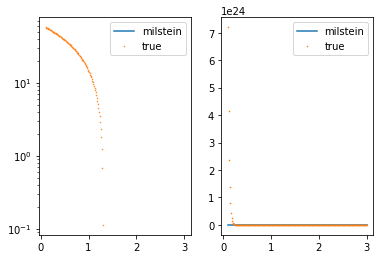

In [7]:
bins = np.linspace(0.1, 3, x_data_test.shape[0]).reshape(-1, 1)
p_current = tf.convert_to_tensor(10.5+0*x_data_test)
p_next = tf.convert_to_tensor(bins)

pdf_true = GPModelSimple2.milstein_pdf(p_next, p_current, step_size, true_drift_diffusivity)

pdf = GPModelSimple2.milstein_pdf(p_next, p_current, step_size, model_milstein)

# print(p_next)

fig, ax = plt.subplots(1, 2,)
ax[0].semilogy(bins, np.array(tf.convert_to_tensor(pdf).numpy()).ravel(), label="milstein");
ax[0].semilogy(bins, np.array(tf.convert_to_tensor(pdf_true).numpy()).ravel(),".",markersize=1, label="true");
ax[0].legend()
ax[1].plot(bins, np.array(tf.convert_to_tensor(tf.math.exp(pdf)).numpy()).ravel(), label="milstein");
ax[1].plot(bins, np.array(tf.convert_to_tensor(tf.math.exp(pdf_true)).numpy()).ravel(),"x",markersize=1, label="true");
ax[1].legend()

In [8]:
p_current = tf.convert_to_tensor([1.5], dtype=tf.float64)
p_next = tf.convert_to_tensor([0.8], dtype=tf.float64)
pdf = GPModelSimple2.milstein_pdf(p_next, p_current, step_size, model_milstein)

print(pdf)

tf.Tensor([-128.75721609], shape=(1,), dtype=float64)


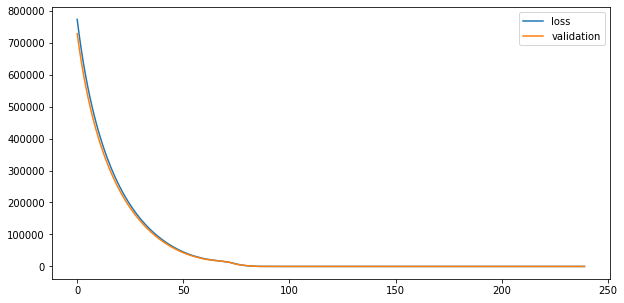

In [9]:
# train the model
delay = 10

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"][delay:], label='loss')
hist_axes.plot(hist.history["val_loss"][delay:], label='validation')

if "distortion" in hist.history:
    hist_axes.plot(np.array(hist.history["distortion"][delay:]), label='distortion')
if "f_distortion" in hist.history:
    hist_axes.plot(np.array(hist.history["f_distortion"][delay:]), label='f-distortion')
hist_axes.legend();

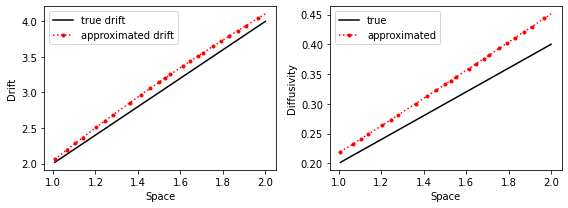

In [10]:
rng = np.random.default_rng(random_seed)

plot_results_functions(sde_i.drift_diffusivity,
                       true_drift_diffusivity,
                       x_data_test, y_data_test, rng,
                       data_transform_network=None,
                       data_transform_true=None);
